# Regresiones y $\chi^2$


Importo las librerías necesarias:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit

Y seteo propiedades de los gráficos:

In [2]:
plt.rcParams["figure.figsize"] = (11,6)
plt.rcParams.update({'font.size': 14})

Defino la función para ajustar (uso una lineal, pero usen la que corresponda):

In [3]:
def f(x, a, b):
    return a * x + b

Defino los datos (acá pongo una lineal más algo de ruido aleatorio, pero irían sus datos):

In [4]:
x = np.arange(20)
xerr = 0 * np.ones(len(x)) # sin errores en x!
y =  np.arange(20) + 0.5*np.random.randn(len(x)) # una lineal con fluctuaciones gaussianas
yerr = max(y)/50 + 0.02*y # por ej, un valor común a todas y una parte porcentual

Ajusto la función a los datos:

In [5]:
# ajusto:
init_guess = [0,0] # esto es importantísimo para ajustes no lineales!
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True) # popt son los parámetros del ajuste, pcov la "matriz de covarianza"
perr = np.sqrt(np.diag(pcov)) # los errores de los parámetros del ajuste son la raíz cuadrada de la diagonal de la matriz de covarianza

print('Resultados del ajuste:')
for i in range(len(popt)):
  print('Parámetro ' + str(i) + ': ' + str(popt[i]) + " \u00B1 " + str(perr[i]))

Resultados del ajuste:
Parámetro 0: 0.979466085991245 ± 0.02169237002183932
Parámetro 1: 0.20896266279750386 ± 0.1971456134288403


donde el "parametro 0" es la pendiente y el "parametro 1" es la ordenada al origen. Noten que estos resultados NO estan citados aun respetando la convencion de cifras significativas.

Grafico, incluyendo las barras de error:

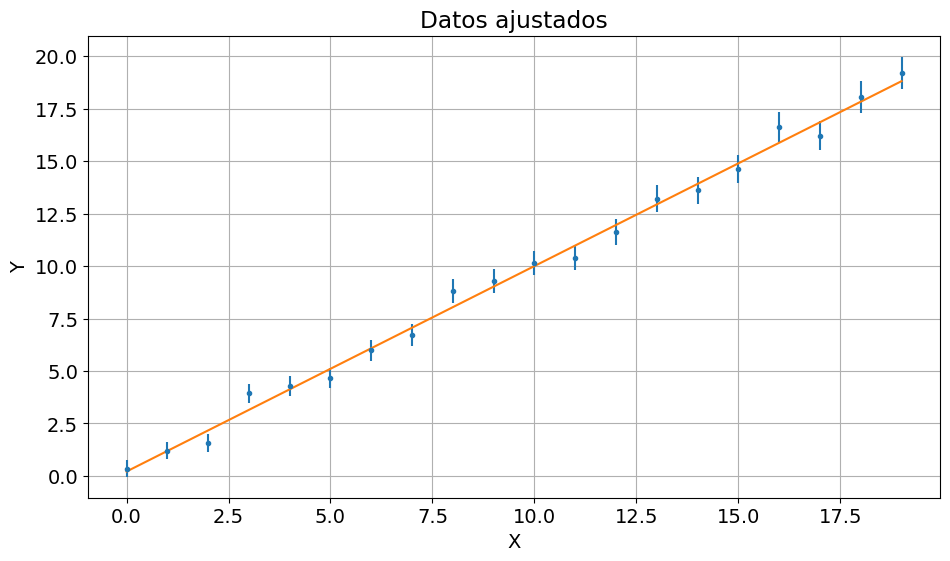

In [6]:
x_ajuste = np.linspace(np.min(x),np.max(x),len(x)*10) # defino un eje horizontal más fino que los puntos que medí, para que el ajuste se vea suave

plt.figure()
plt.title('Datos ajustados')
plt.xlabel('X')
plt.ylabel('Y')
plt.errorbar(x, y, yerr, xerr, '.')
plt.plot(x_ajuste,f(x_ajuste,popt[0],popt[1]))
plt.grid(True)
plt.show()

R^2 o coeficiente de correlacion de Pearson:



Aqui lo vamos a calcular a partir de una expresion que es equivalente a la que vimos en clase, concretamente estamos usando:

$$
R^2 = 1 - \frac{ \sum_i^N [y_i - f(x_i)]^2}{\sum [y_i - \bar{y}]^2}
$$.

En las siguientes lineas calculamos cada termino de esta expresion y por ultimo computamos $R^2$:

In [11]:
residuals = y - f(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)

r_squared = 1 - (ss_res / ss_tot)

print("R^2: ", r_squared)

R^2:  0.9939490347182875


Ajustar por cuadrados mínimos es minimizar la distancia de los datos a lo esperado por el modelo propuesto, pesados por el error:

$$\chi^2 = \sum\left(\frac{y_\text{medido}-y_\text{modelo}}{\sigma_{y_i}}\right)^2$$

Si el modelo propuesto se corresponde a los datos medidos, al calcular el $\chi^2$ ("el estadístico") se obtienen resultados que andan cerca de $\nu$, que es la cantidad de grados de libertad del ajuste (#datos - #parámetros de ajuste). Si $\chi^2$ es mucho más grande que $\nu$, es indicativo de un ajuste pobre; si es algo más grande, que el ajuste no responde completamente a los datos, o que los errores fueron subestimados. Si, en cambio, $\chi^2<\nu$, es factible que el modelo esté sobreajustado: que se esté ajustando el ruido, o que los errores hayan sido sobreestimados.

Ahora consideremos que se miden los datos de nuevo: es esperable que $\chi^2$ vaya a dar levemente distinto, porque los datos van a ser levemente distintos, aunque seguramente dentro de las incertezas experimentales. Resulta que, si el modelo elegido es el correcto, los $\chi^2$ obtenibles en mediciones sucesivas siguen la distribución de probabilidades llamada $\chi^2_\nu$ [[link a wikipedia](https://en.wikipedia.org/wiki/Chi-square_distribution)]:

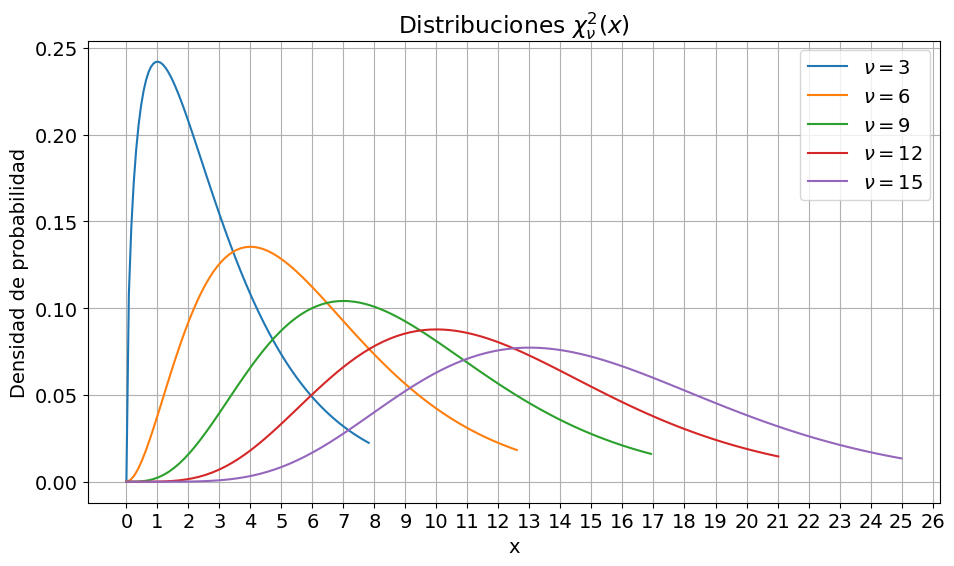

In [7]:
nus = np.array([3,6,9,12,15]) # para qué nu's quiero plotear la chi^2_nu

plt.figure()
plt.title(r'Distribuciones $\chi^2_\nu(x)$')
plt.xlabel('x')
plt.ylabel('Densidad de probabilidad')
plt.xticks(range(100))
plt.grid(True)
for df in nus: # grafica las chi2 correspondientes a los nus elegidos
  x_chi2 = np.linspace(0, stats.chi2.ppf(0.95, df), 100)
  plt.plot(x_chi2,stats.chi2.pdf(x_chi2, df),label=r'$\nu=$'+str(df))
plt.legend()  
plt.show()

Pero, entonces, si es conocida la distribución que describe con qué probabilidad se obtienen, es posible calcular qué tan habitual es obtener el $\chi^2$ que obtuvimos en este ajuste en particular: se le llama "p-valor" a la probabilidad de haber obtenido ese $\chi^2$ o uno peor, si el modelo elegido es el correcto.

Formalmente, el p-valor es la probabilidad de que un valor estadístico sea posible si se da por cierta una hipótesis (a la que se le llama hipótesis nula). En nuestro caso el estadístico es el $\chi^2$, y la hipótesis nula es que el modelo elegido para ajustar es el que describe correctamente el fenómeno observado. Entonces, podemos decir que:

- Si el p-valor es muy bajo, indica que sería muy raro obtener esos datos si el modelo es el correcto. Es decir: o el modelo no es el correcto, o el modelo sí es el correcto pero se tuvo mucha mala suerte y justo lo medido no parece responder al modelo. En el lenguaje de la estadística, "se rechaza la hipótesis nula".

- Si el p-valor es alto, indica que los datos son altamente esperables si el modelo es el correcto. Es decir: o el modelo es el correcto, o las mediciones se parecen al modelo propuesto por una cuestión de azar. Por lo tanto, que un p-valor sea alto no garantiza que el modelo sea el correcto, sino simplemente que el modelo propuesto ajusta lo suficientemente bien a los datos.

Un umbral aceptado para rechazar la hipótesis nula (al que se llama "nivel de significancia") es que p < 0.05, pero depende de la disciplina. Siempre hay que tener en cuenta que este criterio es para rechazar la hipótesis nula: que p sea alto no permite aceptarla.

Calculemos el $\chi^2$ y su correspondiente p-valor para los datos que ajustamos:


In [8]:
# Recursos necesarios para calcular el chi^2 y su p-valor:
puntos = len(x)
params = len(popt)
grados_libertad = puntos - params
y_modelo = f(x,popt[0],popt[1])

# calculo el chi^2 y su p-valor:
chi_cuadrado = np.sum(((y-y_modelo)/yerr)**2)
p_chi = stats.chi2.sf(chi_cuadrado, grados_libertad)
# interpretamos el resultado:
print('chi^2: ' + str(chi_cuadrado))
print('p-valor del chi^2: ' + str(p_chi))

if yerr[0]==0:
    print('No se declararon errores en la variable y.')
elif p_chi<0.05:
    print('Se rechaza la hipótesis de que el modelo ajuste a los datos.')
else:
    print('No se puede rechazar la hipótesis de que el modelo ajuste a los datos.')

chi^2: 12.779128909664708
p-valor del chi^2: 0.8045236757982765
No se puede rechazar la hipótesis de que el modelo ajuste a los datos.


Además, sabemos que los residuos $\left(y_\text{medido}-y_\text{modelo}\right)$ deben ser aleatorios y no estar correlacionados con ninguna otra variable, ni correlacionados entre sí. Si presentan una distribución no aleatoria, es indicativo de que el modelo no está ajustando bien a los datos.

Veamos:

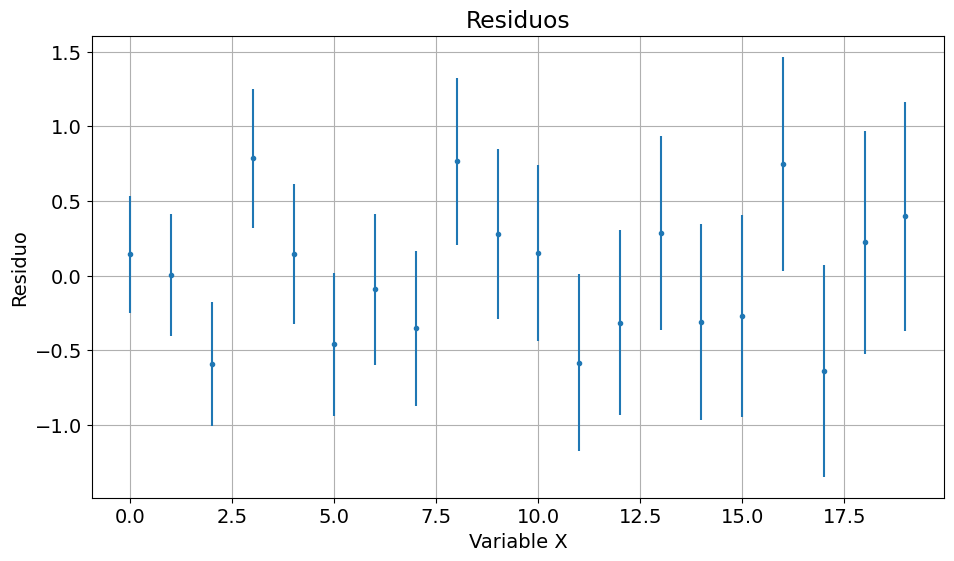

In [9]:
# los calculo:
residuo = y-y_modelo

# los grafico:
plt.figure()
plt.title('Residuos')
plt.xlabel('Variable X')
plt.ylabel('Residuo')
plt.errorbar(x, residuo, yerr, xerr, '.')
plt.grid(True)
plt.show()

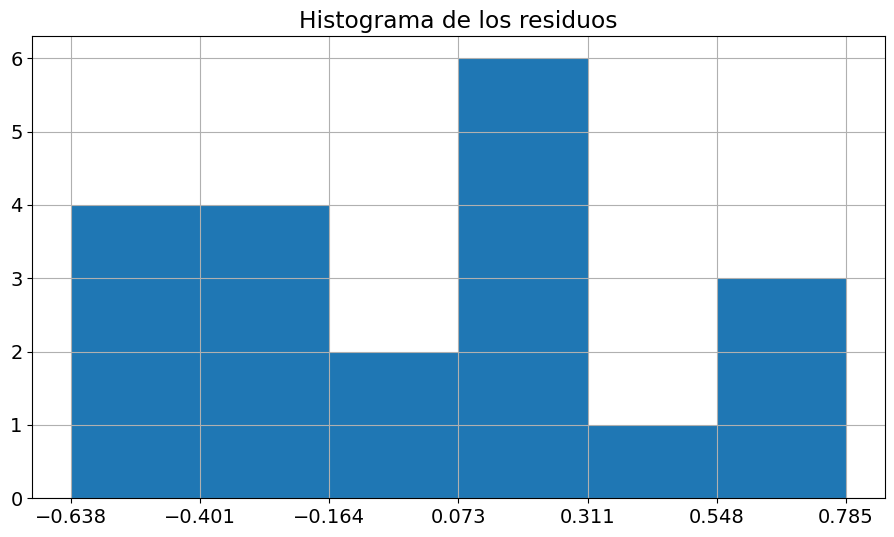

In [10]:
# y el histograma
plt.figure()
data_hist = plt.hist(residuo, bins='auto') # 'auto' es el máximo entre Freedman-Diaconis y Sturges. Quitándolo, el default es 10.
plt.xticks(data_hist[1]) # son los extremos de los bines.
plt.title('Histograma de los residuos')
plt.grid(True)
plt.show()